# Lab 2 : Classification

### Group 3 - Members:

_Tai Chowdhury_<br>
_Apurv Mittal_<br>
_Ravi Sivaraman_<br>
_Seemant Srivastava_<br>


## Data Preparation Part 1

As discussed in Lab 1, we have acquired the Australian Weather dataset from Kaggle portal. It contains 10 years of weather data collected from many locations across Australia. These are daily weather observations. There are 145,459 observations with 23 attributes in the original dataset. 

We have chosen `RainTomorrow` (categorical) and `Rainfall` (continuous) as predictor variables. RainTomorrow is a categorical attribute which indicates whether it is going to rain tomorrow - yes or no. Rainfall is a continuous attribute that measures amount of rainfall each of the particular locations have received (in mm). Using our models, we will be able to design an algorithm where the bureau can help to predict rainfall for different regions in Australia.

In this Lab 2 assignment, we have measured the accuracy and effectiveness of our model for categorical variable RainTomorrow by using 10-fold cross validation against the confusion matrix measurements like: Precision, Recall and Accuracy. We have explored the methods of logistic regression and support vector machine (SVM) models on our dataset. 

We have used `scikit-learn` packages for our exploration. We ran logistic regression models with all the available solvers in the `scikit-learn` package and compare the effictiveness and accuracy of the model to predict `RainfallTomorrow`. We also measured the duration of model run from each models to compare model performance and efficiency as well.
 
To get started, we will start with loading all the necessary packages for our analysis. We will start our analysis with `df_impute` which is the imputed dataframe from our last explanatory data analysis Lab 1 project. Using this dataframe will ensure data consistency for all the labs going forward.

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy import stats
import warnings
from shapely.geometry import Point
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [ ]:
#Ignore Warnings on final

warnings.filterwarnings('ignore')

In [ ]:
#Original Data
df = pd.read_csv("weatherAUS.csv")

In [ ]:
df.head()

#### Dropping columns

We decided to drop `Date` and `Location` as they are not pertinent to our analysis in this Lab 2 project.

In [ ]:
df = df.drop(['Date', 'Location'], axis = 1)
df.head()


We imputed data in EDA project by substituting the missing and `NaN` values. We are reusing the imputed data from EDA (Lab1) project.
Here is the link to the EDA for reference:

https://nbviewer.jupyter.org/github/ravisiv/AussieWeatherEDA/blob/c0ba412cb75da21eba386ea9ea39f645ad6af1d0/DS7331_Lab1_Group3_Ravi_Taifur_Seemant_Apurv_Submission.ipynb


In [ ]:
# Read the Imputed Australia weather data
df_impute = pd.read_csv("weatherAUS_imputed.csv")

In [ ]:
#  View the top rows of the data imported
df_impute.head()

The imputed data doesn't include any null or missing values. Also, we have dropped the columns like: Date of observation and City Name.

In [ ]:
df_impute_num = df_impute.columns[df_impute.dtypes == 'float64']
df_impute_cat=df_impute.columns[df_impute.dtypes == 'object']
print("Numeric Variables:", df_impute_num)
print("Categorical Variables:", df_impute_cat)

Before continuing further, we need to check which variables are numeric and which are not. As the models expect numerical variables. We will filter and identify non-numeric variables.

`WindGustDir`, `WindDir9am`, `WindDir3pm`, `RainToday` and `RainTomorrow`are not numeric. Here `RainTomorrow` is our response variable. we handle the other variables with hot-one-encoding later in the flow.

In [ ]:
#Keep the original data
df_model = df_impute.copy()

Creating a new DataFrame `df_model` for modeling to avoid any changes to the original dataset `df_impute`.

In [ ]:
# Create a new variable to Identify if it RainToday

df_model["IsRainToday"] = df_impute['RainToday']

# Replacing No with 0 and Yes with 1.

df_model['IsRainToday'].replace({'No': 0, 'Yes': 1},inplace = True)


Assigning `0` to No values and `1` to Yes values in `RainToday` (Changed to `IsRainToday`)

In [ ]:
print("df_impute", df_impute.shape)
print("df_model", df_model.shape)


In [ ]:
# Printing the values to check if the data looks good

df_model.head()

### One-hot encoding

Before we create our models, we need to format our attributes. We are converting `RainToday` and `RainTomorrow` into numeric variables to `0` and `1`. We also decided to go ahead with one-hot-encoding `WindGustDir`, `WindDir9am`, and `WindDir3pm` attributes based on the direction of the wind. 

In [ ]:
# perform one-hot encoding using dummies

gust_df = pd.get_dummies(df_model.WindGustDir,prefix='GustDir', drop_first= True)
wind3pm_df = pd.get_dummies(df_model.WindDir3pm,prefix='Wind3pm', drop_first= True)
wind9am_df = pd.get_dummies(df_model.WindDir9am,prefix='Wind9am' , drop_first= True)
df_model = pd.concat((df_model,gust_df, wind3pm_df, wind9am_df),axis=1) # add back into the dataframe


We decided to do one-hot-encoding using dummies function as machine learning algorithms and models requires numerical values for both input and output attributes.

Since the dummies function creates a variable for each unique value, we are dropping the first variable to avoid multicollinearity among the variables as the value for the last variable can be interpreted from the values for other variables created as part of one-hot encoding.



In [ ]:
# Drop categorical columns

df_model = df_model.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

After conversions, we are removing these categorical attributes to avoid duplicates as we have those data in numerical format. We are added the newly formatted attributes and rest of the continuous attributes into a new dataframe - df_model. We will use the new dataframe for modeling.

Reference: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [ ]:
#Check if Yes is replaced as 1

print("Are there 1's and 0's in the RainToday column?", 
      (df_model['IsRainToday'].sum() > 0) and (df_model['IsRainToday'].sum() < len(df_model['IsRainToday'])))

#Non zero output means there is a mixture of 1's and 0's


Checking if the data imputation happened accurately.

In [ ]:
df_model_num = df_model.columns[df_model.dtypes != 'object' ]
df_model_cat=df_model.columns[df_model.dtypes == 'object']
print("Numeric Variables:", df_model_num)
print("Categorical Variables:", df_model_cat)

Check if all the numerical variables are accurately created and if we still have any non-numeric data.

Assigning the `RainTomorrow` as our response variable (y) and all other variables include one-hot-encoded values as X.

In [ ]:
X=df_model[df_model_num]
y = df_model.RainTomorrow
print('features shape:', X.shape) 
print('target shape:', y.shape )

#### Scaling

We will be using scaled data for our models. We have used the scaling feature as part of our customed function for running our classifications and regression models. We will discuss more in details in the modeling sections.

#### New Feature

We are adding a new classification feature called `RainfallAmount` which has four values - `None` (0), `Low`(1), `Moderate`(2) and `High`(3). We are creating this feature from `Rainfall` feature from our dataframe. The data is numerical due to the requirement of the execution of the classification models.

In [ ]:
# New Feature - RainfallAmount

def rain_classifier(row):
    if row["Rainfall"] > 30:
        return 3
    elif row["Rainfall"] > 10 and row["Rainfall"] < 30:
        return 2
    elif row["Rainfall"] > 1 and row["Rainfall"] < 10:
        return 1
    else:
        return 0

df_model["RainfallAmount"] = df_impute.apply(rain_classifier, axis=1)



### Data Distribution

Check if the data distribution is balanced or not for the response variable `RainTomorrow`.

In [ ]:
       

fig = plt.figure(figsize = (8,5))
axes = fig.subplots(nrows=1, ncols=2)

df_model['RainTomorrow'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

fig = plt.figure(figsize = (8,5))
df_model['RainfallAmount'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy', "lightblue", "blue"], alpha = 0.9, rot=0)
plt.title('RainfallAmount Indicator None(0), Low(1), Medium(2) and High(3) in the Imbalanced Dataset')
plt.show()

As expected, we see the data for `RainTomorrow` is imbalanced. Majority of the data is for `No` rain vs. `Yes` for `RainTomorrow`.

We can observe that the presence of `0` and `1` is almost in the `78:22` ratio. We will be cognizant of the fact that our model may be not very effective if we don't solve for imbalance. We will discuss and adjust for this imbalance in our analysis.

## Data Preparation Part 2

In [ ]:
df_model_copy = df_model.copy()

In [ ]:
df_model.info()

The above dataframe has float64, object, int64, and uint8 data formats. Float64, int64, and uint8 are all numerical data type. Object is a string data type. 

#### Response Variables

We have three response features in our current dataframe. They are `RainTomorrow`, `Rainfall`, and `RainfallAmount`. `RainTomorrow` and `RainfallAmount` are for our classification models. `Rainfall` is used for continuous regression models. Our primary focus is on `RainTomorrow` and `RainfallAmount` as the prediction for `Rainfall` is not very accurate. We will present the accuracy of this feature in later section. 

In [ ]:
df_model.describe().transpose()

We ran summary statistics on the final model dataset. We can see the various satistical summary of the features. We see some large variations in the dataset like Evaportaion ranges from 0 to 145, Rainfall varies from 0 mm to 371 mm. Which are huge variation but as determined during `EDA` (Lab 1) those are not outliers and for our analysis we will consider then as valid observations.

### Regression Models

In this section we create Regression Models for continous response variable - `Rainfall`.

In our dataset, `Rainfall` is the continous response variable that measures the Rainfall in mm on the day of the observation which is referenced as `Today` in our dataset. We are going to create regression models for this feature and predict the values.

We are creating the following continuous regression models: 

`Linear Regression`: this regression is ordinary least squares linear regression. It fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

`LASSO`: LASSO (least absolute shrinkage and selection operator) uses a penalized least squares approach that squeezes the regression coefficients to 0 when the penalty is large.  The algorithm starts with a large penalty and gradually relaxes the penalty to allow for a single variable to be added into the model (the coefficient is no longer 0).  

`RFE` (Recursive Feature Elimination): this regression features ranking with recursive feature elimination. The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

References:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

## Modeling And Evaluation 1

For our model performance measurement, we will use precision and accuracy. We are using those because we found the accuracies are very close across all the models. So we want to select on more performance metric for model evaluation. 


`Accuracy` — is a ratio of correctly predicted observation to the total observations. It is a very important aspect to define the success of a model but just the measurement on its own can be deceiving if the observations are not equal for each class. In such cases we might be predicting accurately for one particular class with large observation and may not do very well for other classes.

`Precision` — is the ratio of correctly predicted positive observations to the total predicted positive observations. Precision = TP/TP+FP  

`Weighted Average` — can be calculated on various output variables of the classification report like Precision, Recall, f1-score. As the name suggests it gives the weighted average of the parameter based on the number of observations or values for each class.

`Macro Average` — similar to weighted average, macro average can also be calculated on various output variables of the classification report like Precision, Recall, f1-score. However, the similarity ends here as unlike weighted average, we don't use weights based on the number of observations, rather equal weights are given to each class to calcualte the value. This tells us if the Precision is as good if the dataset was balanced.

References:
https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report

## Modeling And Evaluation 2

As per MiniLab,  we are going to use `Stratified` because our response feature (`RainTomorrow` and `RainfallAmount`) data is disproportionaly distributed. 

For `RainTomorrow`, response - `No` is very high compare to response - `Yes`. 

For `RainfallAmount`, the response - `None` is very high compare to `Low`, `Moderate`, and `High`.  

To rectify this issue, we are going to use `StratifiedSplit` for cross validation. Then we are going to use `10-fold` cross validation to improve our model accuracies. We have compare the performances between shuffle and stratified cross validated models in our MiniLab project. A snippet from MiniLab for reference below:

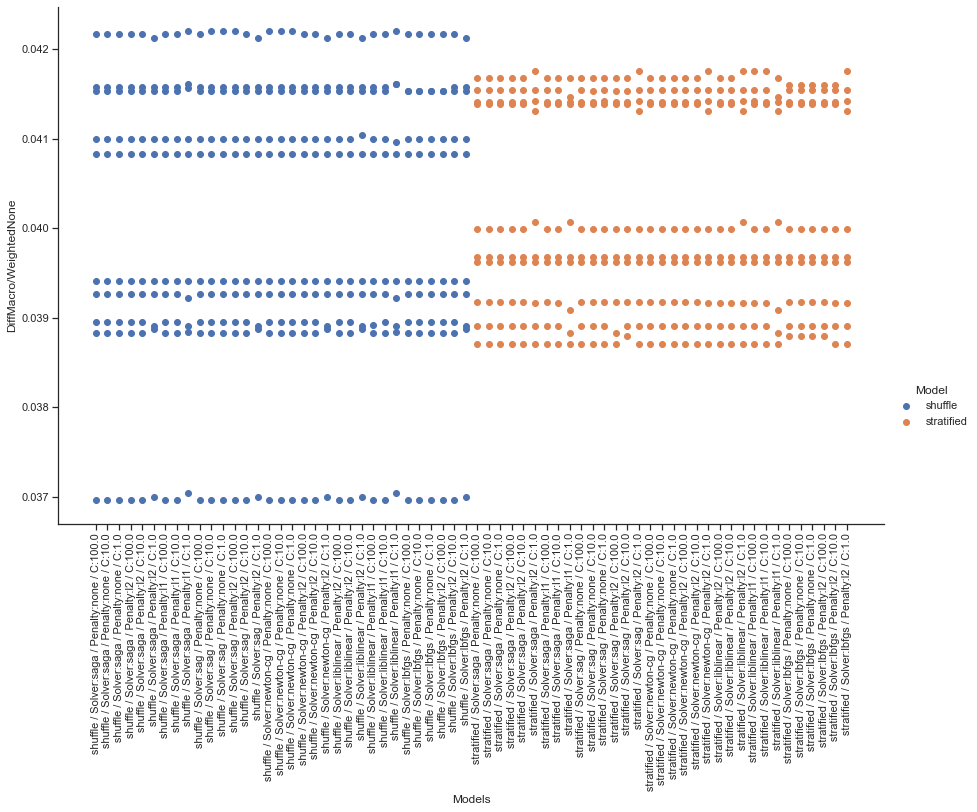

### Macro Avg vs Weight Avg Precision comparisons
__*As discussed in MiniLab*__ we did our analysis by plotting the difference between the `Macro Avg` precision and `Weighted Avg` precision for all the models. 

  `DiffMacro/WeightedNone` — takes the `Macro Average` and `Weighted Average` of `Precision` from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the `Precision` values based on how the data is split. 
  
  `DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a `balanced` data.
  
The smaller the difference between `Weight Avg` and `Macro Avg`, the model is closer to real world and also consistent.  

Also, plotted the models classified into `Shuffle` and `Stratified` against `DiffMacro/WeightedNone` of precision (difference between Macro and Weighted Average of Precision of non-balanced data).
From the above plot, we notice that the difference between Macro Average of Precision and Weighted Average of Precision varies as below:

Balanced Data - `0.091` to `0.097`

Non-Balanced Data - `0.037` to `0.042`

There are two major takeaways from the above plots. 

1. The `StratifiedKFolds` data sees lower variation compared to `ShuffleSplit`.

2. Its evident that the difference between Macro Average of Precision and Weighted Average of Precision varies a lot more for `balanced` data compared to `non-balanced` data. 

Since, lower variation is desired to get more stable and consistent model. We decide to go ahead with `Stratified` and non-balanced data. In our model we have hypertuned `shuffle` as `True` for `StratifiedKFolds` as well. Also, we know `StratifiedKFolds` works well with non-balanced data.

__With above points in mind, we will continue with `Stratified` and `non-balanced` data models.__

## Modeling And Evaluation 3

The following models are the continuous regression and classification models:

### Linear Regression Model

In Linear Regression Model, the dependent variable (`Rainfall`) is dependent of independent variables (the other 16 features). This is an instance of multiple linear regression, which means, the independent variable is dependent of multiple features.

Linear Regression works with continous variables and categorical variables doesn't translate well. To make categorical variables, we used One-hot encoding to convert them to numerical vectors. The downside of it, it may introduce multi-collineriaty, but we can minimize by taking only the important features.

There are multiple ways of doing Linear Regression, LASSO, Ridge and simple linear regression. We create models of all types and get the best model that has least RMSE values.

The function below builds linear regression models:

1. Ordinary Least squares

LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

2. LASSO
Linear Model trained with L1 prior as regularizer (aka the Lasso)

The optimization objective for Lasso is:

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).


3. RFE (Recursive Feature Elimination)

Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

We create models of these and then store them in a dataframe. We then compare the RMSE of these models, and find which model has lowest RMSE and take as the best model of Regression.

 
 #### References for definitions
 1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
 2. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
 3. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

### Grid Search Param for Linear Models

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso
from timeit import default_timer as timer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import ElasticNet


model_stats_rainfall = {}

def create_models_continous(df, iterations):

    X = None
    y = None
    if "Rainfall" in df:
        y = df["Rainfall"].values # get the labels we want
        del df["Rainfall"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    random_state = 123
    njobs = -1
    
    models = ["LinearRegression", "Lasso", "Elasticnet"]
    
    for model in models:
        start_time = timer()
        clf = None
        if model == "LinearRegression":
            clf = LinearRegression(n_jobs=njobs)
        elif model == "Lasso":
            clf = Lasso(alpha=0.05)
        elif model == "Elasticnet":    
            clf = ElasticNet(random_state=123)
    
        cv_ret = cross_validate(clf, X, y, cv=10, scoring="neg_root_mean_squared_error", n_jobs=-1 , return_estimator=True)
        end_time = timer()
        elapsed_time = end_time - start_time
        print(clf.__class__.__name__," rmse are\n", cv_ret['test_score'], '\ntook ', elapsed_time, "seconds.\n")
        
        model_stats_rainfall[clf.__class__.__name__] = [cv_ret, elapsed_time]
         

In [ ]:
from sklearn.model_selection import StratifiedKFold


df_model = df_model_copy.copy()
del df_model["RainTomorrow"]

cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=123)
create_models_continous(df=df_model, iterations=cv)



### Classification Models

In this, we create classification models for two response variables:

   1. `RainTomorrow`, that has binary classification (`Yes` = `1`, `No` = `0`).
    
   2. `RainfallAmount`, this is multiclass, has variables `None` (`0`), `Low` (`1`), `Moderate` (`2`), and `High` (`3`).

First, we are running models for `RainTomorrow`. 

We build the following models:

    1. Random Forest Classifier
    2. KNN Classifier
    3. Gaussian Naive Bayes Classifier
    4. Linear classifiers with stochastic gradient descent
    5. Linear Support Vector Classification
    6. XGBoost Classifier
    7. Logistic Regression Classifier
    
    
   ### Random Forest Classifier
   A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.
   
   
   Random forest is collection of decision trees where each set of trees have different set of hyper parameters, trained on different subsets of data, and create prediction. Using the model, we can visualize each tree and notice which independent features are used for prediction value computation (‘RainTomorrow’ = Yes/No or `Rainfall` values ). 
   For our model, using `RandomForestClassifier` for classification and `RandomForestRegressor` for regression, we have created our model. 
   We have set the number of trees parameter to `200`. 
   
   `n_job`’ parameter indicates the number of jobs the model runs in parallel. In our case, we have set it to -1 which indicates the computation will be dispatched to all the CPUs.
   
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
   
   Definitions are from the following documentation.
   ##### Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
   

### KNN

We used the `K-Nearest Neighbors` non-parametric method for our model. 

KNN suffers from the curse of dimensionality due to a large dimensional data set. If the data set is small, KNN works well with smaller set of variables but as the numbers of variables increase, as in case in our model, the dataset size should also increase exponentially to get good prediction. KNN is not considered to be the best approach when we have large number of variables. However, the large number of variables in our dataset is due to One-Hot encoding and not necessarily are different variables. So, we don’t consider we need to do dimensionality reduction for our dataset and continued with KNN with existing dataset.

Another challenge with KNN is to identify the best possible value of K to reduce the noise as well keep the predictability high. It a trade-off between bias and variance. Small value of K typically provides lower bias but higher variance.

We ran KNN for various values of K between 1 and 9 and identified at `8` we are getting the best accuracy. 

We decided to complete our analysis for KNN at `K=8`.

### Logistic Regression
Logistic regression model is used to examine relationship between independent variable(s) and dependent variable `RainTomorrow`.
The Logistic Regression model uses various hyper tuning parameters to create a model. 

   1. `Model Type`
   2. `Class Weight`
   3. `Solver`
   4. `C`
   5. `Penalty`
   6. `Iterations`

In `MiniLab` project we ran a function runs for different values of Solver, C, Penalty and used 10 iterations.

##### Model Type

   1. `Shuffle`
   2. `Stratified`

`ShuffleSplit` — is similar to `Cross Validation` where we can specify the percentage of split for train and test data. However, in regular cross-validation, the data is not split randomly, so, it is good to shuffle the targets before applying the `cross-validation`.

`Stratified` — CV technique is very useful with unbalanced dataset. As discussed above our dataset is not balanced and rightly so, we don't expect it to rain and no-rain days to be equal in Australia. The data is expected to be unbalanced and expected to be such in future as well. So using stratified sampling techniques gives us the ability to preserve the proportion of the Rain days vs non-rain days in our dataset. We can be confident that the Train and Test split data is not leaving out important information like entire dataset is of `No` rain days which will give highly inaccurate output eventhough the accuracy might be maintained. 
In `Stratified` sampling, the data is k-1 split in favor of Train vs Test data.

We have established earlier that for our models we are moving ahead with StratifiedKFold CV.

References: 
https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d

https://mclguide.readthedocs.io/en/latest/sklearn/cv.html

##### Solver Options

Scikit-learn comes with five different solver options. Each solver minimize the cost function. Here are the five options:

`newton-cg` — A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the second derivatives.

`lbfgs` — Stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It approximates the second derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets.

`liblinear` — Library for Large Linear Classification. Uses a coordinate descent algorithm. Coordinate descent is based on minimizing a multivariate function by solving univariate optimization problems in a loop. In other words, it moves toward the minimum in one direction at a time. It performs pretty well with high dimensionality. It does have a number of drawbacks. It can get stuck, is unable to run in parallel, and can only solve multi-class logistic regression with one-vs.-rest.

`sag` — Stochastic Average Gradient descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Fast for big datasets.

`saga` — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.
Reference for above definitions: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451

##### Penalty
Used to specify the norm used in the penalization. The `newton-cg`’, `sag` and `lbfgs` solvers support only `l2` penalties. `elasticnet` is only supported by the `saga` solver. If `none` (not supported by the `liblinear` solver), no regularization is applied.

`L1` or `Lasso` — (`LASSO` is Least Absolute Shrinkage and Selection Operator) uses a penalized least squares approach that squeezes the regression coefficients to 0 when the penalty is large. The algorithm starts with a large penalty and gradually relaxes the penalty to allow for a single variable to be added into the model (the coefficient is no longer `0`). `LASSO` uses `L1` method.

`L2` or `Ridge` — adds a penalty equal to the square of the magnitude of coefficients. `L2` will not yield sparse models and all coefficients are shrunk by the same factor (not eliminated). Ridge regression and SVMs use this method.

`elasticnet` — Procedure identical to `LASSO` however the penalty is different. `elasticnet` uses a combination of both the `LASSO` penalty as well as the `RIDGE` regression penalty. It combine both `L1` & `L2` methods.

`none` — No penalty
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
Reference for Penalty definitions: https://www.statisticshowto.com/regularization/

##### C

`C` is cost, which we run with `1.0`, `10.0` and `100.0` for each combination of Solver and Penalty.
If the solver doesn't support the penalty, those are skipped.

As discussed earlier we ran various different combinations of above parameters in `MiniLab` and came to the conclusion that following combination gives the best model for Logistic Regression for our dataset.

`Model` - Stratified

`Solver` - Saga

`C` - 100

`Penalty` - None

### Naïve Bayes

`Naïve Bayes` are set of supervised learning algorithms where naïve assumption of conditional independence between every pair of features given the values of class variable. For our classification models, we have chosen Gaussian Naïve Bayes that follows Gaussian normal distributes and support continuous values in features. It creates probability values for response features. 

In our case, it creates the probability values for `Yes` and `No` for `RainTomorrow`. We have not set any specification for this modeling technique.


https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

### Linear Support Vector Classification

`Linear Support Vector Classification` is similar to `SVC` (from `Minilab`) with parameter `kernel=’linear’`, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and scales better to large numbers of samples such as our dataset.

`penalty` : Specifies the norm used in the penalization. Accepts `l1` and `l2`. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.

`loss`: Specifies the loss function. Accepts ‘hinge’ and ‘squared_hinge’. ‘hinge’ is the standard SVM loss while ‘squared_hinge’ is the square of the hinge loss. Certain combinations like penalty='l1' and loss='hinge' is not supported.

`dualbool` : Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features. In our dataset this is true, so we will use dual as `False`.

`tolfloat`: Tolerance for stopping criteria. default=1e-4

`Cfloat` : Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. default=1.0

`multi_class` : Determines the multi-class strategy if y contains more than two classes. "ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes. While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute. If "crammer_singer" is chosen, the options loss, penalty and dual will be ignored.

In our dataset `RainTomorrow` is boolean, however, `RainfallAmout` is a multi-class response variable.
`class_weight` : Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
`random_state` : We are defaulting this as `123` for all our models

`max_iter`: The number of iterations to be run. We are setting it to be 10.


##### Reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso
from timeit import default_timer as timer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

def create_models_classification(name, model, df, response_feature,iterations):
    start_time = timer()
    X = None
    y = None
    if response_feature in df:
        y = df[response_feature].values # get the labels we want
        del df[response_feature] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    random_state = 123
    njobs = -1
    scoring_metric = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}
    
    cv = StratifiedKFold(n_splits=iterations,shuffle=True, random_state=random_state)
    
    cv_ret = cross_validate(model, X, y, cv=iterations, n_jobs=4, scoring=scoring_metric, return_estimator=True)

    best_estimator = cv_ret['estimator'][0]
    #This is the best estimator, now we are building the model with entire data
    
    y_hat = best_estimator.predict(X)
    conf_mat = confusion_matrix(y,y_hat)
    y_01 = np.where(y =="Yes", 1, [0])
    y_hat_01 = np.where(y_hat =="Yes", 1, [0])
    fpr, tpr, threshold = metrics.roc_curve(y_01, y_hat_01) 
    end_time = timer()
    elapsed_time = end_time - start_time
    
    print(name," accuracies are\n", cv_ret['test_acc'], '\ntook ', elapsed_time, "seconds.")
    
    return [cv_ret, elapsed_time, conf_mat,fpr, tpr]

### KNN find the best K

In [ ]:
# For KNN: 
df_model["RainTomorrow"] = df_impute["RainTomorrow"]
df_model["RainTomorrow"] = df_model["RainTomorrow"].map(dict(Yes=1, No=0))
y= df_model["RainTomorrow"].values
del df_model["RainTomorrow"]
X = df_model.values


In [ ]:
#Knn (model run):

# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
  
  
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=123)
  
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
  
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
      
    # Compute traning and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
  
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

max_accuracy = max_value = max(test_accuracy)

best_k = np.argmax(test_accuracy) + 1


#Reference for KNN: https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/

In [ ]:
np.argmax(test_accuracy)

### Grid Search Param for Classification Models


In [ ]:
param_sgd = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

param_GNB = {'var_smoothing': np.logspace(0,-9, num=100)}

param_rf = { 
    'n_estimators': [100, 150],
    'max_features': ['auto', 'sqrt', 'log2']
}

k_range = list(range(1, 9))
param_knn = dict(n_neighbors=k_range)

param_svc = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

param_xgboost = {
            'min_child_weight': np.arange(1, 5, 0.5).tolist(),
        }

param_logistic = {'C': [100], 'solver': ['saga'], 'penalty':['none'], 'class_weight':['balanced']}

params_grid = [param_knn,param_GNB,param_sgd,param_rf, param_logistic, param_xgboost ]


In [ ]:
# The following are the list of models and the parameters 

from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


column_names = df_model.columns


#we took the best logistic regression from the mini-lab
models = [
        KNeighborsClassifier(n_neighbors=best_k),
        GaussianNB(), 
        SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,max_iter=5,tol=None, n_jobs=-1, random_state=123),
        RandomForestClassifier(n_jobs=-1, random_state=123),
        LogisticRegression(n_jobs=-1, random_state=123),
        XGBClassifier(objective='binary:logistic')
     ]

    
model_stats_raintomorrow = {}
for index, model in enumerate(models):
    df_model = df_model_copy.copy()
    #Delete Rainfall Amount (as this is a classification value of Rainfall)
    if "RainfallAmount" in df_model:
        del df_model["RainfallAmount"]
        
    clf = GridSearchCV(estimator=model, param_grid=params_grid[index],n_jobs=-1)
    stats = create_models_classification(name=model.__class__.__name__,model=clf,df=df_model,response_feature="RainTomorrow", iterations=10)
    model_stats_raintomorrow[model.__class__.__name__] = stats

### Models for RainfallAmount

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

models = [
    KNeighborsClassifier(n_neighbors=best_k),
    GaussianNB(), 
    SGDClassifier(n_jobs=-1, random_state=123),
    RandomForestClassifier(n_jobs=-1, random_state=123),
    LogisticRegression(n_jobs=-1, random_state=123),
    XGBClassifier(objective='binary:logistic')
]

model_stats_rainfallamount = {}

for index, model in enumerate(models):
    df_model = df_model_copy.copy()
    if "RainTomorrow" in df_model:
        del df_model['RainTomorrow']

    if "IsRainToday" in df_model:        
        del df_model['IsRainToday']

    #RainfallAmount is a classification of Rainfall, having Rainfall will give model the predicting value, 
    #so remove Rainfall 
    if "Rainfall" in df_model:   
        del df_model['Rainfall']
   
    clf = GridSearchCV(estimator=model, param_grid=params_grid[index],n_jobs=-1)
    stats = create_models_classification(name=model.__class__.__name__,model=clf,df=df_model,response_feature="RainfallAmount", iterations=10)
    model_stats_rainfallamount[model.__class__.__name__] = stats

## Modeling And Evaluation 4

### Visualization of Models

#### Random Forest Decision Tree for RainTomorrow

In [ ]:
model_stats_raintomorrow['RandomForestClassifier'][0]['estimator'][1].best_estimator_

In [ ]:
estimator_rf = model_stats_raintomorrow['RandomForestClassifier'][0]['estimator'][1].best_estimator_[0]

#Decision tree diagram for the first index (first tree):
from sklearn import tree
plt.figure(figsize = (25,12))
tplt = tree.plot_tree(estimator_rf, proportion = True, fontsize=10,max_depth=3,class_names = ['No', 'Yes'], filled = True, feature_names = column_names)
plt.show()

Explain the Tree

#### Random Forest Decision Tree for RainfallAmount

In [ ]:
estimator_rf = model_stats_rainfallamount['RandomForestClassifier'][0]['estimator'][1].best_estimator_[0]

#Decision tree diagram for the first index (first tree):
from sklearn import tree
plt.figure(figsize = (25,12))
tplt = tree.plot_tree(estimator_rf, proportion = True, fontsize=10,max_depth=3,
                      class_names = ['None', 'Low', 'Moderate', 'High'], filled = True, feature_names = column_names)
plt.show()

#### ROC Curves

`AUC` - `ROC` curve is a performance measurement for the classification problems at various threshold settings. 

`ROC` is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the `AUC`, the better the model is at predicting `0`s as `0`s and `1`s as `1`s. 

The ROC curve is created by plotting the `True Positive Rate` (`TPR`) against the `False Positive Rate` (`FPR`).

`ROC` curves plot 2 quantities from the confusion matrices

`Sensitivity` (Ability to correctly predict when an event occurs)

`Specificity` (False Positives)

If a model is doing very well, then most of the predicted probabilities will be close to `0` or `1`

###### Reference: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

## Modeling And Evaluation 5

Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

### Statistical comparison of Models

### Pairwise Comparison

There are several Pairwise Comparison tests that can be performed to compare the various models and their output being significantly different from each other. When we have more than two groups, it is inappropriate to simply compare each pair using a t-test because of the problem of multiple testing. The correct way to do the analysis is to use a one-way analysis of variance (`ANOVA`) to evaluate whether there is any evidence that the means of the populations differ. If the ANOVA leads to a conclusion that there is evidence that the group means differ, we might then be interested in investigating which of the means are different. 
We ran three different comparison techniques:

    1. Tukey's
    2. BonFerroni
    3. Kruskal-Wallis
    
`Tukey’s`: Tukey's multiple comparison test is also called Tukey's honestly significant difference test `Tukey's HSD`. The test compares the difference between each pair of means with appropriate adjustment for the multiple testing. The results are presented as a matrix showing the result for each pair as a P-value. The Tukey multiple comparison test, like both the t-test and ANOVA, assumes that the data from the different groups come from populations where the observations have a normal distribution and the standard deviation is the same for each group.

###### Reference : http://www.blackwellpublishing.com/specialarticles/jcn_8_304.pdf


`Bonferroni`: Bonferroni's method provides a pairwise comparison of the means. To determine which means are significantly different, we must compare all pairs. To counter higher error rate, the Bonferroni method adjusts the confidence level for each individual interval so that the resulting simultaneous confidence level is equal to the value specified.

###### Reference: https://www.spcforexcel.com/knowledge/comparing-processes/bonferronis-method



`Kruskal-Wallis` : The Kruskal–Wallis test is a nonparametric approach to the one-way ANOVA. The procedure is used to compare three or more groups on a dependent variable that is measured on at least an ordinal level.
The null hypothesis of the Kruskal-Wallis test is that the mean ranks of the groups are the same. As the nonparametric equivalent one-way ANOVA, Kruskal-Wallis test is called one-way ANOVA on ranks. Unlike the analogous one-way ANOVA, the nonparametric Kruskal-Wallis test does not assume a normal distribution of the underlying data.

###### Reference: https://www.sciencedirect.com/topics/medicine-and-dentistry/kruskal-wallis-test



### RainTomorrow

In [ ]:
from scipy.stats import f_oneway
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.multicomp as multi
from scipy import stats


GaussianNB_stat = model_stats_raintomorrow['GaussianNB'][0]["test_acc"].tolist()
SGDClassifier_stat = model_stats_raintomorrow['SGDClassifier'][0]["test_acc"].tolist()
RandomForestClassifier_stat = model_stats_raintomorrow['RandomForestClassifier'][0]["test_acc"].tolist()
LogisticRegression_stat = model_stats_raintomorrow['LogisticRegression'][0]["test_acc"].tolist()
KNeighborsClassifier_stat = model_stats_raintomorrow['KNeighborsClassifier'][0]["test_acc"].tolist()
XGBClassifier_stat = model_stats_raintomorrow['XGBClassifier'][0]["test_acc"].tolist()


    
anova_result = f_oneway(GaussianNB_stat, SGDClassifier_stat, RandomForestClassifier_stat, LogisticRegression_stat,
                       KNeighborsClassifier_stat,XGBClassifier_stat)

df_testscores_rt = pd.DataFrame({'score':GaussianNB_stat + SGDClassifier_stat +RandomForestClassifier_stat + LogisticRegression_stat+KNeighborsClassifier_stat+XGBClassifier_stat,
                   'model': np.repeat(["GaussianNB", "SGDClassifier", "RandomForestClassifier","LogisticRegression","KNeighborsClassifier","XGBClassifier"], repeats=10)}) 

tukey = multi.pairwise_tukeyhsd(endog=df_testscores_rt['score'],
                          groups=df_testscores_rt['model'],
                          alpha=0.05)


multi_comp = multi.MultiComparison(df_testscores_rt['score'],
                          df_testscores_rt['model'],
                          )

tukey_2 = multi_comp.tukeyhsd(alpha=.05)
kruskal = multi_comp.kruskal()
allpair_holm = multi_comp.allpairtest(stats.ttest_rel, method='Holm', alpha=.05)
allpair_bonf = multi_comp.allpairtest(stats.ttest_rel, method='bonf', alpha=.05)

rank = multi_comp.getranks()

print (allpair_holm[0])
print (allpair_bonf[0])
print(tukey_2)
print(kruskal)



In [ ]:
plt_t = df_testscores_rt.boxplot("score",by="model", showfliers=True, figsize= (14,8))

plt.title('Model Comparisons RainTomorrow for Accuracy')


#### RainfallAmount

In [ ]:
from scipy.stats import f_oneway
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.multicomp as multi
from scipy import stats


GaussianNB_stat = model_stats_rainfallamount['GaussianNB'][0]["test_acc"].tolist()
SGDClassifier_stat = model_stats_rainfallamount['SGDClassifier'][0]["test_acc"].tolist()
RandomForestClassifier_stat = model_stats_rainfallamount['RandomForestClassifier'][0]["test_acc"].tolist()
LogisticRegression_stat = model_stats_rainfallamount['LogisticRegression'][0]["test_acc"].tolist()
KNeighborsClassifier_stat = model_stats_raintomorrow['KNeighborsClassifier'][0]["test_acc"].tolist()
XGBClassifier_stat = model_stats_rainfallamount['XGBClassifier'][0]["test_acc"].tolist()

anova_result = f_oneway(GaussianNB_stat, SGDClassifier_stat, RandomForestClassifier_stat, 
                        LogisticRegression_stat, KNeighborsClassifier_stat,XGBClassifier_stat)

df_testscores_ra = pd.DataFrame({'score':GaussianNB_stat + SGDClassifier_stat +RandomForestClassifier_stat + LogisticRegression_stat+KNeighborsClassifier_stat+XGBClassifier_stat,
                   'model': np.repeat(["GaussianNB", "SGDClassifier", "RandomForestClassifier","LogisticRegression","KNeighborsClassifier","XGBClassifier"], repeats=10)}) 


multi_comp = multi.MultiComparison(df_testscores_ra['score'],
                          df_testscores_ra['model'],
                          )

tukey_2 = multi_comp.tukeyhsd(alpha=.05)
kruskal = multi_comp.kruskal()
allpair_holm = multi_comp.allpairtest(stats.ttest_rel, method='Holm', alpha=.05)
allpair_bonf = multi_comp.allpairtest(stats.ttest_rel, method='bonf', alpha=.05)

rank = multi_comp.getranks()

print (allpair_holm[0])
print (allpair_bonf[0])
print(tukey_2)
print(kruskal)


In [ ]:
df_testscores_ra.boxplot("score",by="model", showfliers=True, figsize= (14,8))
plt.title('Model Comparisons RainfallAmount for Accuracy')


#### Rainfall (Linear)

In [ ]:
from scipy.stats import f_oneway
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.multicomp as multi
from scipy import stats


Linear_stat = model_stats_rainfall['LinearRegression'][0]["test_score"].tolist()
Lasso_stat = model_stats_rainfall['Lasso'][0]["test_score"].tolist()
Elasticnet_stat = model_stats_rainfall['ElasticNet'][0]["test_score"].tolist()


#Convert them in abs value, as sklearn gives them in negative (but the values are not really negative)

Linear_stat =[abs(number) for number in Linear_stat]
Lasso_stat = [abs(number) for number in Lasso_stat]
Elasticnet_stat = [abs(number) for number in Elasticnet_stat]


all_stats = Linear_stat + Lasso_stat + Elasticnet_stat  
    
anova_result = f_oneway(Linear_stat, Lasso_stat, Elasticnet_stat)

df_testscores_r = pd.DataFrame({'score':all_stats,
                   'model': np.repeat(["LinearRegression", "LASSO", "ElasticNet"], repeats=10)}) 

tukey = multi.pairwise_tukeyhsd(endog=df_testscores_r['score'],
                          groups=df_testscores_r['model'],
                          alpha=0.05)


multi_comp = multi.MultiComparison(df_testscores_r['score'],
                          df_testscores_r['model'],
                          )

tukey_2 = multi_comp.tukeyhsd(alpha=.05)
kruskal = multi_comp.kruskal()
allpair_holm = multi_comp.allpairtest(stats.ttest_rel, method='Holm', alpha=.05)
allpair_bonf = multi_comp.allpairtest(stats.ttest_rel, method='bonf', alpha=.05)

rank = multi_comp.getranks()

print (allpair_holm[0])
print (allpair_bonf[0])
print(tukey_2)
print(kruskal)


In [ ]:

df_testscores_r.boxplot("score",by="model", showfliers=True, figsize= (14,8))
plt.title('Model Comparisons Rainfall for RMSE')

#Plot references
# http://www.r-graph-gallery.com/84-tukey-test


In [ ]:
#df_model_copy = df_model.copy()

## Modeling And Evaluation 6

Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.


In [ ]:
import time
import numpy as np

start_time = time.time()

clf = model_stats_rainfallamount['RandomForestClassifier'][0]['estimator'][1].best_estimator_
importances = clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
column_names_rt = df_model_copy.columns
column_names_rt = column_names_rt.drop('RainfallAmount')
column_names_rt = column_names_rt.drop('RainTomorrow')
print(column_names_rt)

In [ ]:
#Attribute Importance - Random Forest Model (RainTomorrow Classification)

from sklearn.inspection import permutation_importance
clf = model_stats_raintomorrow['RandomForestClassifier'][0]['estimator'][1].best_estimator_
start_time = time.time()


df_model = df_model_copy.copy()

y = df_model["RainTomorrow"].values


if "RainfallAmount" in df_model:
    del df_model["RainfallAmount"]

if "RainTomorrow" in df_model:
    del df_model["RainTomorrow"]

X = df_model.values
column_names_rt = df_model.columns
    
result = permutation_importance(
    clf, X, y, n_repeats=10, random_state=123, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=column_names_rt)


plt.figure(figsize=(20,8))
forest_importances.plot.bar(yerr=result.importances_std)

plt.show()


Explain

In [ ]:
#Attribute Importance - Random Forest Model ('RainfallAmount')

from sklearn.inspection import permutation_importance
start_time = time.time()

clf = model_stats_rainfallamount['RandomForestClassifier'][0]['estimator'][1].best_estimator_
start_time = time.time()


df_model = df_model_copy.copy()

y2 = df_model["RainfallAmount"].values


if "RainfallAmount" in df_model:
    del df_model["RainfallAmount"]

if "RainTomorrow" in df_model:
    del df_model["RainTomorrow"]

if "IsRainToday" in df_model:
    del df_model["IsRainToday"]
    
if "Rainfall" in df_model:
    del df_model["Rainfall"]
   

X2 = df_model.values
column_names_ra = df_model.columns



result = permutation_importance(
    clf, X2, y2, n_repeats=10, random_state=123, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances2 = pd.Series(result.importances_mean, index=column_names_ra)

#Visuals RainfallAmount Attribute importance
plt.figure(figsize=(20,8))
forest_importances2.plot.bar(yerr=result.importances_std)

plt.show()


explain

## Deployment

Our models are primarily designed for meteorologists. At the same time, these can be very useful for event organizers in cities across the country – mostly important for outdoor events. The favored model can be also useful for government organizations like military (Navy). The model not only predicts if it’s going to Rain Tomorrow (next day), It also predicts the amount of `Rainfall` for today in amount of rain fell (mm) as well as classifies as `Low`, `Medium` and `High`. Due to our ability to give the data which is easily interpretable for everyone, this is useful for the everyone. It can be integrated by the weather channels and apps as well. 


The model’s value can be measured in terms of its accuracy; higher the accuracy better the value of the model over existing models in use. Some parties may value our models higher than others depending upon how important the accuracy of prediction of Rainfall for their business or area of operations.


Our models can be integrated to the existing feed of weather related data which is useful for our model to predict accurately. This data is easily available from government websites. 


Data from those sources can be integrated with our model and build an APIs for anyone to consume and monetize by the count of API calls.


As we know weather is an ever-changing event and due to climate change, predictive models needs to evolve continuously. The validity of our models need to be tested against the recorded information and improve our models daily with the new data (models can be built within hours).


Additional data points may be required like seasons, time of the year, impact of natural events like cyclones/hurricanes, wild fires, El Niño and La Niña effects etc.


Overall, our classification models will be more useful since those clearly indicates weather condition for all the interested parties.

## Exceptional Work

# Conclusion




# Seemant

## XGBoost Model

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

In [ ]:
df_model["RainTomorrow"] = df_model["RainTomorrow"].map(dict(Yes=1, No=0))
y= df_model["RainTomorrow"].values
del df_model["RainTomorrow"]
X = df_model.values
df_model["RainTomorrow"] = df_impute["RainTomorrow"]

In [ ]:
# Split into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=123)

In [ ]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(objective='binary:logistic')
xgbc.fit(X_train,y_train)

In [ ]:
# accuracy of XGBoost Model
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,roc_curve, roc_auc_score
y_predxgb = xgbc.predict(X_test)
report = classification_report(y_test, y_predxgb)
print(report)
print("Accuracy of the XGBoost Model is:",accuracy_score(y_test,y_predxgb)*100,"%")
cm = confusion_matrix(y_test, y_predxgb)
sns.heatmap(cm, annot=True,cmap="YlGnBu")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()
# Reference: https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97
# Reference: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package/code

# Random Forest Classifier Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=300) # increasing number of trees for better accuracy
classifier.fit(X_train, y_train)

In [ ]:
# accuracy of Random Forest Classifier Model
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,roc_curve, roc_auc_score
y_pred2 = classifier.predict(X_test)
report3 = classification_report(y_test, y_pred2)
print(report3)
print("Accuracy of the Random Forest Model is:",accuracy_score(y_test,y_pred2)*100,"%")
cm3 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm3, annot=True)
plt.title("Confusion Matrix for Random Forest Classifier Model")
plt.show()
# Reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# Reference: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package/code

In [ ]:
y_pred_proba = classifier.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['Logistic regression', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Random Forest Classifier')

In [ ]:
#Importance for RFE 
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=LinearSVR(random_state=0, tol=1e-5), step=1, cv=cv, scoring='accuracy')
rfecv.fit(X, y)

# Modeling and Evaluation

### Explanation of Evaluation Matrices

#### Macro Avg vs Weight Avg Precision comparisons

As we couldn't pick the models just from Accuracy, we are further our analysis by plotting the difference between the Macro Avg precision and Weighted Avg precision for all the models.

`DiffMacro/WeightedNone` — takes the Macro Average and Weighted Average of Precision from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the Precision values based on how the data is split.

`DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a balanced data.

The smaller the difference between Weight Avg and Macro Avg, the model is closer to real world and also consistent.

After running the big `Logistic Regression` model for several combinations. We got output for 660 models.

To compare the outputs and make it easier to identify the most appropriate model in terms of accuracy, precision and other factors applicable for Machine Learning models. We decided to put a list of subset of variables including:

`Model` — specifies which technique was used for the logistic model. In this case its between ShuffleSplit and Stratified.

`AccuracyNone` —  specifies the Accuracy observed by the model where data was not `balanced`.

`DiffMacro/WeightedNone` — takes the `Macro Average` and `Weighted Average` of `Precision` from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the Precision values based on how the data is split. More details about Precision and Averages is provided below. This variation is calculated on the non `balanced` data.

`AccuracyBalanced` — specifies the Accuracy observed by the model where data was `balanced`.

`DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a `balanced` data.

### Important Terms

`Accuracy` — is a ratio of correctly predicted observation to the total observations. It is a very important aspect to define the success of a model but just the measurement on its own can be deceiving if the observations are not equal for each class. In such cases we might be predicting accurately for one particular class with large observation and may not do very well for other classes.

`Precision` — is the ratio of correctly predicted positive observations to the total predicted positive observations. Precision = TP/TP+FP  

`Weighted Average` — can be calculated on various output variables of the classification report like Precision, Recall, f1-score. As the name suggests it gives the weighted average of the parameter based on the number of observations or values for each class.

`Macro Average` — similar to weighted average, macro average can also be calculated on various output variables of the classification report like Precision, Recall, f1-score. However, the similarity ends here as unlike weighted average, we don't use weights based on the number of observations, rather equal weights are given to each class to calcualte the value. This tells us if the Precision is as good if the dataset was balanced.

References:
https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report

### Cross Validation

In these models we used two different methodologies for cross validation namely `Shuffle` and `Stratified`.

`ShuffleSplit`  — is similar to `Cross Validation` where we can specify the percentage of split for train and test data. However, in regular cross-validation, the data is not split randomly, so, it is good to shuffle the targets before applying the `cross-validation`.


`Stratified` — CV technique is very useful with unbalanced dataset. As discussed above our dataset is not balanced and rightly so, we don't expect it to rain and no-rain days to be equal in Australia. The data is expected to be unbalanced and expected to be such in future as well. So using stratified sampling techniques gives us the ability to preserve the proportion of the Rain days vs non-rain days in our dataset. We can be confident that the Train and Test split data is not leaving out important information like entire dataset is of `No` rain days which will give highly inaccurate output eventhough the accuracy might be maintained. 

In `Stratified` sampling, the data is k-1 split in favor of Train vs Test data.


References: 
https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d
https://mclguide.readthedocs.io/en/latest/sklearn/cv.html


# Tai

In [ ]:
#df_model["RainTomorrow"] = df_model["RainTomorrow"].map(dict(Yes=1, No=0))
df_model["RainTomorrow"] = df_impute["RainTomorrow"]
y= df_model["RainTomorrow"].values
del df_model["RainTomorrow"]
X = df_model.values
yhat = np.zeros(y.shape)
column_names_f = df_model.columns

In [ ]:
#For Classification 2
del df_model['Rainfall']
del df_model['IsRainToday']
del df_model["RainTomorrow"]
y2= df_model["RainfallAmount"].values
del df_model["RainfallAmount"]
X2 = df_model.values
yhat2 = np.zeros(y.shape)
column_names_f2 = df_model.columns

In [ ]:

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat = clf.predict(X[test])

    total_accuracy = mt.accuracy_score(y[test], yhat)
    print ('Random Forest accuracy', total_accuracy)

In [ ]:

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)
for train, test in cv.split(X2,y2):
    clf.fit(X2[train],y2[train])
    yhat2 = clf.predict(X2[test])

    total_accuracy = mt.accuracy_score(y2[test], yhat2)
    print ('Random Forest accuracy', total_accuracy)

In [ ]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()

plot_class_acc(y,yhat,title="Random Forest")

In [ ]:
#List of decision trees - there are 150 decision trees

clf.estimators_


# it helps to see how many 'decision trees' are associated with our random forest model. 
# From the list, we can visualize some of the 'trees'. We are picking the first index

In [ ]:
#Decision tree diagram for the first index (first tree):

from sklearn import tree
plt.figure(figsize = (15,10))
tree.plot_tree(clf.estimators_[1], filled = True)

#Given the diagram below it is hard to visualize.

In [ ]:
#We cannot produce diagram for all decision trees in one instance. 
#We can visualize the data portion only for all the decision trees. 
#We can see how all the decision trees are being classified

for i in range(len(clf.estimators_)):
    print(tree.export_text(clf.estimators_[i]))


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
#Attribute Importance - Random Forest Model

from sklearn.inspection import permutation_importance
start_time = time.time()
result = permutation_importance(
    clf, X[test], y[test], n_repeats=10, random_state=123, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=column_names_f)

In [ ]:
#Attribute Importance - Random Forest Model ('RainfallAmount')

from sklearn.inspection import permutation_importance
start_time = time.time()
result = permutation_importance(
    clf, X2[test], y2[test], n_repeats=10, random_state=123, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=column_names_f2)

In [ ]:
#Visuals
plt.figure(figsize=(20,8))
forest_importances.plot.bar(yerr=result.importances_std)

plt.show()


In [ ]:
#Visuals RainfallAmount Attribute importance
plt.figure(figsize=(20,8))
forest_importances.plot.bar(yerr=result.importances_std)

plt.show()


In [ ]:
df_model_ra = df_model.copy()

# Ravi

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import mean_squared_error

model_stats_columns=["Iteration", "MSE", "RMSE", "clf", "Time"]

def get_model_stats(model_clf,y_test, y_hat, target_names):
   
    mse = mean_squared_error(y_test,y_hat)
    rmse = mean_squared_error(y_test,y_hat, squared=False)

   
    # Create ROC Curve
    y_test_01 = np.where(y_test =="Yes", 1, [0])
    y_hat_01 = np.where(y_hat =="Yes", 1, [0])

    #Create a dict of these stats for class weight
    #dict will contain stats for balanced on one run, None for the next run

    stats_data = [mse, rmse]


    stats_row = stats_data 

    return stats_row





In [ ]:
#Linear Regression Model

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from timeit import default_timer as timer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

def create_lin_reg_models(df, iterations):
    
    X = None
    y = None
    if "Rainfall" in df:
        y = df["Rainfall"].values # get the labels we want
        del df["Rainfall"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    print (X)
    print (y)
    cv_data = ShuffleSplit(n_splits=iterations,
                             test_size  = 0.2, random_state = 123)
    
    
    cv_data.get_n_splits(X, y)
       
    #Initialize variables
    iter_num=1
    rows = []
    target_names = [0, 1]
    classes = None    
    scl_obj = StandardScaler()
    #lr_clf = LinearRegression(n_jobs=4)
    #lr_clf = linear_model.Lasso(alpha=0.1)
    #estimator = SVR(kernel="linear")
    estimator = LinearSVR(random_state=0, tol=1e-5)
    lr_clf = RFE(estimator, n_features_to_select=8, step=1)
    
    for train_indices, test_indices in cv_data.split(X,y): 
        starttime = timer()
        X_train = X[train_indices]
        y_train = y[train_indices]

        scl_obj.fit(X_train)

        X_test = X[test_indices]
        y_test = y[test_indices]
            
        try:
            X_train_scaled = scl_obj.transform(X_train) 
            X_test_scaled = scl_obj.transform(X_test)

            lr_clf.fit(X_train_scaled,y_train)  # train object
            y_hat = lr_clf.predict(X_test_scaled) # get test set precitions
            print(lr_clf.coef_)            
            model_stats = get_model_stats(lr_clf,y_test=y_test,y_hat=y_hat, target_names=target_names )

        except Exception as e:
            #print('Error:', str(e))
            raise
        endtime = timer()
        time_taken = endtime - starttime
        row = [iter_num] + model_stats + [lr_clf, time_taken]
        rows.append(row)
        iter_num+=1

    
    #Create a dataframe with the model stats 
    df_ret = pd.DataFrame(rows, columns = model_stats_columns)
    
    df_ret.plot.line(x='Iteration', y='RMSE')
    return df_ret



In [ ]:
#Random Forest

from sklearn.ensemble import RandomForestRegressor
from timeit import default_timer as timer

def create_random_forest_models(df, iterations):
    
    X = None
    y = None
    if "Rainfall" in df:
        y = df["Rainfall"].values # get the labels we want
        del df["Rainfall"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    print (X)
    print (y)
    cv_data = ShuffleSplit(n_splits=iterations,
                             test_size  = 0.2, random_state = 123)
    
    
    cv_data.get_n_splits(X, y)
       
    #Initialize variables
    iter_num=1
    rows = []
    target_names = [0, 1]
    scl_obj = StandardScaler()
    regr = RandomForestRegressor(max_depth=2, random_state=123)
    
    
    for train_indices, test_indices in cv_data.split(X,y): 
        starttime = timer()
        X_train = X[train_indices]
        y_train = y[train_indices]

        scl_obj.fit(X_train)
        
        X_test = X[test_indices]
        y_test = y[test_indices]
            
        try:
            X_train_scaled = scl_obj.transform(X_train) 
            X_test_scaled = scl_obj.transform(X_test)

            regr.fit(X_train_scaled,y_train)  # train object
            y_hat = regr.predict(X_test_scaled) # get test set precitions
            print(y_hat)
            
            model_stats = get_model_stats(regr,y_test=y_test,y_hat=y_hat, target_names=target_names )

        except Exception as e:
            #print('Error:', str(e))
            raise
        endtime = timer()
        time_taken = endtime - starttime
        row = [iter_num] + model_stats + [regr, time_taken]
        rows.append(row)
        iter_num+=1


    #Create a dataframe with the model stats 
    df_ret = pd.DataFrame(rows, columns = model_stats_columns)
    return df_ret



In [ ]:

df_model = df_model_copy.copy()
del df_model['RainTomorrow']
del df_model['IsRainToday']
del df_model['RainfallAmount']


df_ret = create_lin_reg_models(df=df_model,iterations=10)

In [ ]:
del df_model['RainTomorrow']
del df_model['IsRainToday']
del df_model['RainfallAmount']


In [ ]:
def rain_classifier(row):
    if row["Rainfall"] > 30:
        return "High"
    elif row["Rainfall"] > 10 and row["Rainfall"] < 30:
        return "Moderate"
    elif row["Rainfall"] > 1 and row["Rainfall"] < 10:
        return "Low"
    else:
        return "None"

df_model["RainfallAmount"] = df_impute.apply(rain_classifier, axis=1)

df_model


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def create_knn_model(df, response):
    # Split into training and test set
    
    y= df[response].values
    print(y)
    if response in df:
        del df[response]
    if "Rainfall" in df:
        del df["Rainfall"]
    if "RainTomorrow" in df:
        del df["RainTomorrow"]
#    if "IsRainToday" in df:    
#        del df["IsRainToday"]
    
    X = df.values

    pca = PCA(n_components = 2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)
    
    print(y_train)
    neighbors = np.arange(1, 9)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    
    

    # Loop over K values
    for i, k in enumerate(neighbors):
        #knn = KNeighborsClassifier(n_neighbors=k)
        knn =  DecisionTreeRegressor(random_state=123)
        X_train2 = pca.fit_transform(X_train)
        X_test2 =  pca.fit_transform(X_test)
        knn.fit(X_train2, y_train)

        # Compute traning and test data accuracy
        train_accuracy[i] = knn.score(X_train2, y_train)
        test_accuracy[i] = knn.score(X_test2, y_test)
        plt.figure(figsize=(10,8))
        plot_decision_regions(X_train2, y_train, clf=knn, legend=2)
       
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Knn with K='+ str(k))
        plt.show()
    # Generate plot
    plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy for ' + response)
    plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy for ' + response)

    plt.legend()
    plt.xlabel('n_neighbors')
    plt.ylabel('Accuracy')
    plt.show()
    
    
    #find the maximum accuracy and position
    best_k = test_accuracy.argmax()+1

    #Now use that K to predict

    yhat = np.zeros(y.shape) # we will fill this with predictions

    scl = StandardScaler()
    X = scl.fit_transform(X)

    # create cross validation iterator
    cv = StratifiedKFold(n_splits=10)

    # get a handle to the classifier object, which defines the type
    clf = KNeighborsClassifier(n_neighbors=best_k)

    # now iterate through and get predictions, saved to the correct row in yhat
    # NOTE: you can parallelize this using the cross_val_predict method
    for train, test in cv.split(X,y):
        clf.fit(X[train],y[train])
        yhat[test] = clf.predict(X[test])

    total_accuracy = mt.accuracy_score(y, yhat)
    return total_accuracy





In [ ]:
df_model_copy = df_model.copy()
try:
    create_knn_model(df=df_model.head(20000),response='RainTomorrow')
except Exception as e:
    print (e.message)
finally:
    df_model = df_model_copy.copy()

In [ ]:
y= df_model["RainfallAmount"].values
del df_model["RainfallAmount"]
del df_model["Rainfall"]
del df_model["RainTomorrow"]
del df_model["IsRainToday"]
X = df_model.values


In [ ]:
df_model["RainTomorrow"] = df_model["RainTomorrow"].map(dict(Yes=1, No=0))

In [ ]:
df_ret

In [ ]:
total_accuracy

In [ ]:
y

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()

iris.target

## Linear Regression Model

In Linear Regression Model, the dependent variable (`RainfallAmount`) is dependent of independent variables (the other 16 features). This is an instance of multiple linear regression, which means, the independent variable is dependent of multiple features.

Linear Regression works with continous variables and categorical variables doesn't translate well. To make categorical variables, we used One-hot encoding to convert them to numerical vectors. The downside of it, it may introduce multi-collineriaty, but we can minimize by taking only the important features.

There are multiple ways of doing Linear Regression, LASSO, Ridge and simple linear regression. We create models of all types and get the best model that has least RMSE values.

The function below builds linear regression models:

1. Ordinary Least squares

LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

2. LASSO
Linear Model trained with L1 prior as regularizer (aka the Lasso)

The optimization objective for Lasso is:

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).


3. RFE (Recursive Feature Elimination)

Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

We create models of these and then store them in a dataframe. We then compare the RMSE of these models, and find which model has lowest RMSE and take as the best model of Regression.

 
 #### References for definitions
 1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
 2. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
 3. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [ ]:
#Decision Trees

from sklearn.tree import DecisionTreeRegressor
from timeit import default_timer as timer
from sklearn.model_selection import cross_val_score

def create_decision_tree_models(df, iterations):
    
   
    if "Rainfall" in df:
        y = df["Rainfall"].values # get the labels we want
        del df["Rainfall"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    criterion = ["mse", "friedman_mse", "mae", "poisson"]
    
    for crit in criterion:
        regr = DecisionTreeRegressor(criterion=crit, random_state=123)
        score = cross_val_score(regr, X, y, cv=iterations, n_jobs=4)
        print(crit, score)
        #print(regr.tree_)

    #Create a dataframe with the model stats 
#    df_ret = pd.DataFrame(rows, columns = model_stats_columns)
    return None


In [ ]:
df_model = df_model_copy.copy()
if "RainTomorrow" in df_model:
    del df_model['RainTomorrow']

if "IsRainToday" in df_model:        
    del df_model['IsRainToday']

if "RainfallAmount" in df_model:   
    del df_model['RainfallAmount']
    
    
#df_model = df_model.select_dtypes(exclude=['uint8'])

create_models_classification(df=df_model_ohe,iterations=10)

In [ ]:
df_model_copy = df_model.copy()

In [ ]:
df_model.info()

In [ ]:
#Create models

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso
from timeit import default_timer as timer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

def create_models_continous(model, df, iterations):

    X = None
    y = None
    if "Rainfall" in df:
        y = df["Rainfall"].values # get the labels we want
        del df["Rainfall"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    random_state = 123
    njobs = -1
    
    #models = ["LinearRegression", "Lasso", "LinearSVR"]
    models = ["LinearRegression", "Lasso"]

    for model in models:
        clf = None
        if model == "LinearRegression":
            clf = LinearRegression(n_jobs=njobs)
        elif model == "Lasso":
            clf = Lasso(alpha=0.1)
        elif model == "LinearSVR":    
            estimator = LinearSVR(random_state=0, tol=1e-5)
            clf = RFE(estimator, n_features_to_select=8, step=1)
    
        score = cross_val_score(model, X, y, cv=iterations, n_jobs=4, scoring="neg_root_mean_squared_error")
        abs_score = [abs(x) for x in score]
        print(model, abs_score)



        
def create_models_classification(model, df, response_feature,iterations):
    X = None
    y = None
    if response_feature in df:
        y = df[response_feature].values # get the labels we want
        del df[response_feature] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        print ("returning")
        return

    random_state = 123
    njobs = -1
    
    cv = StratifiedKFold(n_splits=iterations,shuffle=True, random_state=random_state)
    
    #models = ["LinearRegression", "Lasso", "LinearSVR"]

    score = cross_val_score(model, X, y, cv=iterations, n_jobs=4, scoring="accuracy")
    print(model, score)
    
        

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#df_model = df_model.select_dtypes(exclude=['uint8'])
models = [# KNeighborsClassifier(n_neighbors=8),
         GaussianNB(), 
    MultinomialNB(),
    SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,max_iter=5, 
                  tol=None, n_jobs=-1, random_state=123),
    RandomForestClassifier(n_estimators=200, max_depth=3, 
                           n_jobs=-1, random_state=123),
    LinearSVC(random_state=123),
    LogisticRegression(n_jobs=-1, random_state=123)]
for model in models:
    df_model = df_model_copy.copy()
    if "RainTomorrow" in df_model:
        del df_model['RainTomorrow']

    if "IsRainToday" in df_model:        
        del df_model['IsRainToday']

    if "Rainfall" in df_model:   
        del df_model['Rainfall']
    
    create_models_classification(model=model,df=df_model,response_feature="RainfallAmount", iterations=10)
    
for model in models:
    df_model = df_model_copy.copy()
    print("coming to models")
    if "RainfallAmount" in df_model:   
        del df_model['RainfallAmount']
        
    #create_models_classification(model=model,df=df_model,response_feature="RainTomorrow", iterations=10)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

list_of_dir = df_impute.WindGustDir.unique()
le.fit(list_of_dir)
le.transform(df_impute.WindGustDir)

In [ ]:
gust_df = le.transform(df_impute.WindGustDir)
wind3pm_df = le.transform(df_impute.WindDir3pm)
wind9am_df = le.transform(df_impute.WindDir9am)

df_model["gust"] =  gust_df.tolist()
df_model["wind3pm"] =  wind3pm_df.tolist()
df_model["wind9am"] =  wind9am_df.tolist()

# Remove original categorical columns
df_model = df_model.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

df_model_copy = df_model.copy()


In [ ]:
df_model_copy = df_model.copy()

In [ ]:

df_model.RainfallAmount

In [ ]:
df_model_copy = df_model.copy()

In [ ]:
df_model_copy.RainTomorrow

In [ ]:
#Impurity-based feature importances can be misleading for high cardinality features (many unique values)
#Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a
#bias toward high-cardinality features and can be computed on a left-out test set
from sklearn.inspection import permutation_importance
start_time = time.time()
result = permutation_importance(
    clf, X[test], y[test], n_repeats=10, random_state=123, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")
forest_importances = pd.Series(result.importances_mean, index=column_names)
plt.figure(figsize = (10,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(x = 'features', y = 'Weights')
#ax.set_title("Feature importances using permutation on Random Forest model")
#ax.set_ylabel("Mean accuracy decrease")
#fig.tight_layout()
plt.show()

In [ ]:
arr_mod = df_model_ohe.toarray()

In [ ]:
len(arr_mod[0])

# Apurv

In [ ]:
df_model["RainTomorrow"] = df_model["RainTomorrow"].map(dict(Yes=1, No=0))
y= df_model["RainTomorrow"].values
del df_model["RainTomorrow"]
X = df_model.values
df_model["RainTomorrow"] = df_impute["RainTomorrow"]


Reference for KNN:
    
https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/

In [ ]:
%%time
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
  
  
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=123)
  
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
  
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
      
    # Compute traning and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
  
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


# create variables we are more familiar with

#y = df_model["RainTomorrow"].values # get the labels we want
#del df_model["RainTomorrow"] # get rid of the class label
#X = df_model.values
yhat = np.zeros(y.shape) # we will fill this with predictions

scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=8)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN accuracy', total_accuracy)



In [ ]:
output= []
for x in yhat:
    if x not in output:
        output.append(x)
print(output)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso
from timeit import default_timer as timer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

X = df_model_ohe
y = y_new
iterations = 10

random_state = 123
njobs = -1

#models = ["LinearRegression", "Lasso", "LinearSVR"]
models = ["LinearRegression", "Lasso"]

for model in models:
    clf = None
    if model == "LinearRegression":
        clf = LinearRegression(n_jobs=njobs).fit(X,y)
    elif model == "Lasso":
        clf = Lasso(alpha=0.1).fit(X,y)
    elif model == "LinearSVR":    
        estimator = LinearSVR(random_state=0, tol=1e-5)
        clf = RFE(estimator, n_features_to_select=8, step=1)

    score = cross_val_score(model, X, y, cv=iterations, n_jobs=4, scoring="neg_root_mean_squared_error")
    abs_score = [abs(x) for x in score]
    print(model, abs_score)

